In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageFilter
import cv2
from skimage import data
from skimage.transform import rotate

In [2]:
%matplotlib notebook

In [3]:
def plot_dwt(dwtlist):
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate(dwtlist):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()
        plt.show()
    return

def plot_dwt2(dwtlist,alpha=.5):
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate(dwtlist):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a[0], interpolation="nearest", cmap=plt.cm.gray)
        ax.imshow(a[1], interpolation="nearest", cmap=plt.cm.gray, alpha=alpha)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()
        plt.show()
    return

def correlate2d(array_left,array_right,weights=False):
    nyleft, nxleft = np.shape(array_left); #print(nyleft,nxleft)
    nyright, nxright = np.shape(array_right); #print(nyright,nxright)
    if nyleft != nyright:
        print('Need same number of rows')
        return 0
    ny = nyleft
    result = []
    
    for i in range(ny):
        leftsignal = np.array(array_left[i,:]); #leftsignal = leftsignal - np.mean(leftsignal)
        rightsignal = np.array(array_right[i,:]); #rightsignal = rightsignal - np.mean(rightsignal)
        thisrow = np.correlate(leftsignal,rightsignal,'full')
        result.append(thisrow)
    corrfun = np.array(result)

    if weights:
        nycorr, nxcorr = np.shape(corrfun)
        offset = int(nxcorr/2)
        ixrcorrange = np.arange(0,nxcorr)-offset
        weights = nxcorr/(offset-np.abs(ixrcorrange))
        for i in range(ny):
            corrfun[i,:] = corrfun[i,:] * weights
    
    return corrfun

def rotate_and_integrate(image,theta_degrees,debug=False):

    if debug:
        # This is just testing that we have the right trim
        print('from inside rotate_and_integrate ...')
        print('... theta_degrees',theta_degrees)
        newimage = rotate(image, theta_degrees, preserve_range=True, mode='constant', cval=255)
        print(np.shape(newimage))
        plt.figure()
        plt.imshow(newimage,cmap=plt.cm.gray)

    newimage = rotate(image, theta_degrees, preserve_range=True, mode='edge')
    ny_image, nx_image = np.shape(image)
    theta_radians = theta_degrees/180*np.pi
    xtrim = int(ny_image/2*np.sin(np.abs(theta_radians)))+1
    ytrim = int(nx_image/2*np.sin(np.abs(theta_radians)))+1
    
    newimage = newimage[ytrim:ny_image-ytrim,xtrim:nx_image-xtrim]

    if debug:
        print('... xtrim',xtrim)
        print('... ytrim',ytrim)
        plt.figure()
        plt.imshow(newimage,cmap=plt.cm.gray)
        ny_image_rotated, nx_image_rotated = np.shape(newimage)
        print('... ny_image_rotated,nx_image_rotated', ny_image_rotated,nx_image_rotated)
        
    newimage_integrated = np.sum(newimage,axis=0)
    return newimage,newimage_integrated

In [4]:
# Loading the image file
# Filename = 'P1000256.png'; offset = 40
# Filename = 'P1000261.png'; offset = 20
# Filename = 'P1000226.png'; offset = 40 # The weird face
Filename = 'P1000270.png'; offset = 60
# Filename = 'P1000218.png'; offset = 30

im = PIL.Image.open(Filename)
imgray = im.convert("L")

<IPython.core.display.Javascript object>


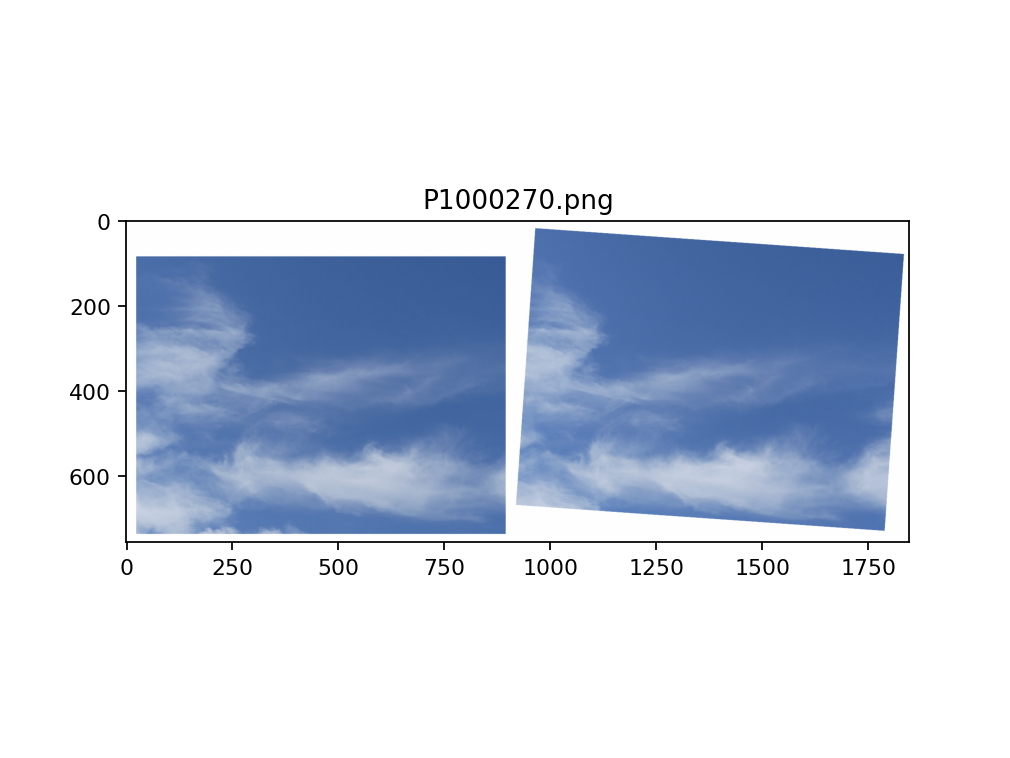

<IPython.core.display.Javascript object>


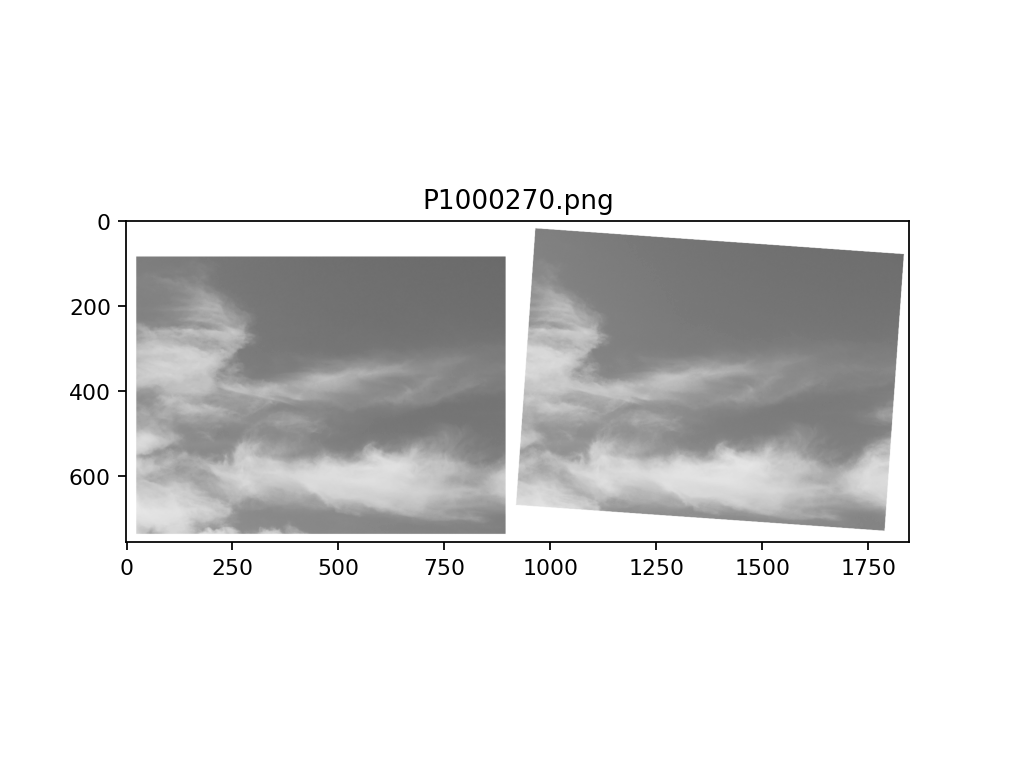

Text(0.5, 1.0, 'P1000270.png')

In [5]:
# Visualizing the original and gray-scale images
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(Filename)

plt.figure()
plt.imshow(np.asarray(imgray), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(Filename)

shape of image = 758 1848
min amplitude = 85
midpoint index x = 924


<IPython.core.display.Javascript object>


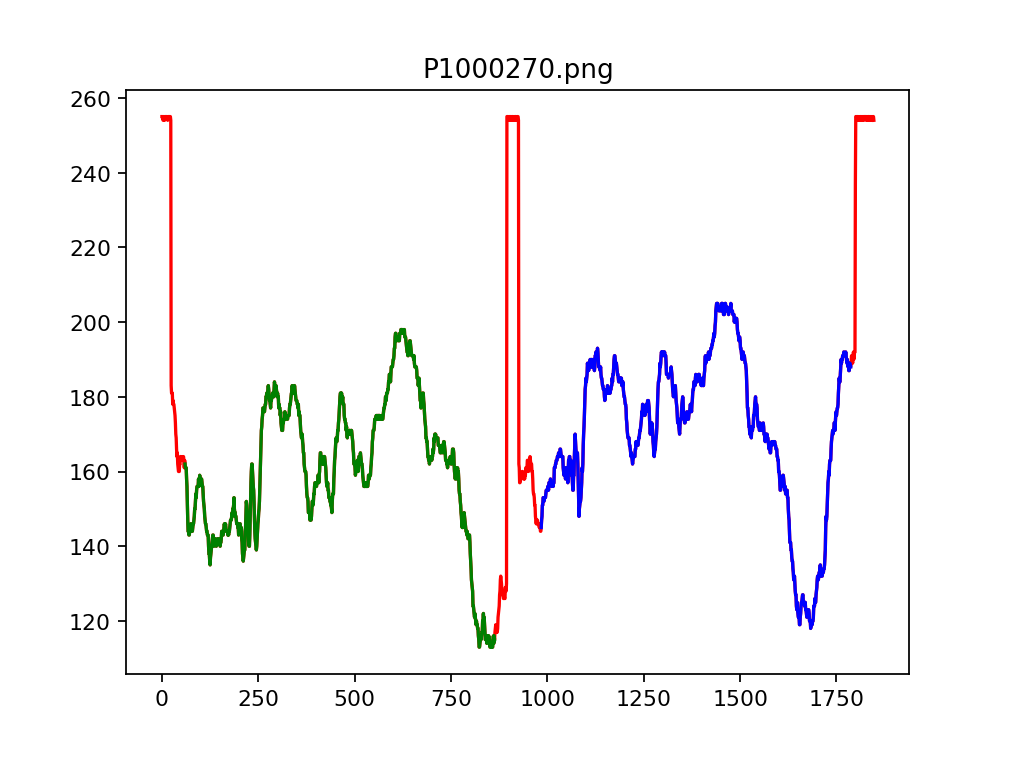

Text(0.5, 1.0, 'P1000270.png')

In [6]:
# Visualizing a single raster (row)
amplitudes = np.asarray(imgray)
ny, nx = np.shape(amplitudes); print('shape of image =', ny,nx)
print('min amplitude =', np.min(amplitudes))
iysample = 340
iysample = 571
ixmid = int(nx/2); print('midpoint index x =',ixmid)
ixrange = np.arange(0,nx)

ixrange_left = np.arange(offset,ixmid-offset)
amps_left_orig = np.real(amplitudes[iysample,ixrange_left])

ixrange_right = np.arange(ixmid+offset,nx-offset)
amps_right_orig = np.real(amplitudes[iysample,ixrange_right])

plt.figure()
plt.plot(ixrange,amplitudes[iysample,:],'r')
plt.plot(ixrange_left,amps_left_orig,'g')
plt.plot(ixrange_right,amps_right_orig,'b')
plt.title(Filename)

mean_left 160.61194029850745
mean_right 171.431592039801


<IPython.core.display.Javascript object>


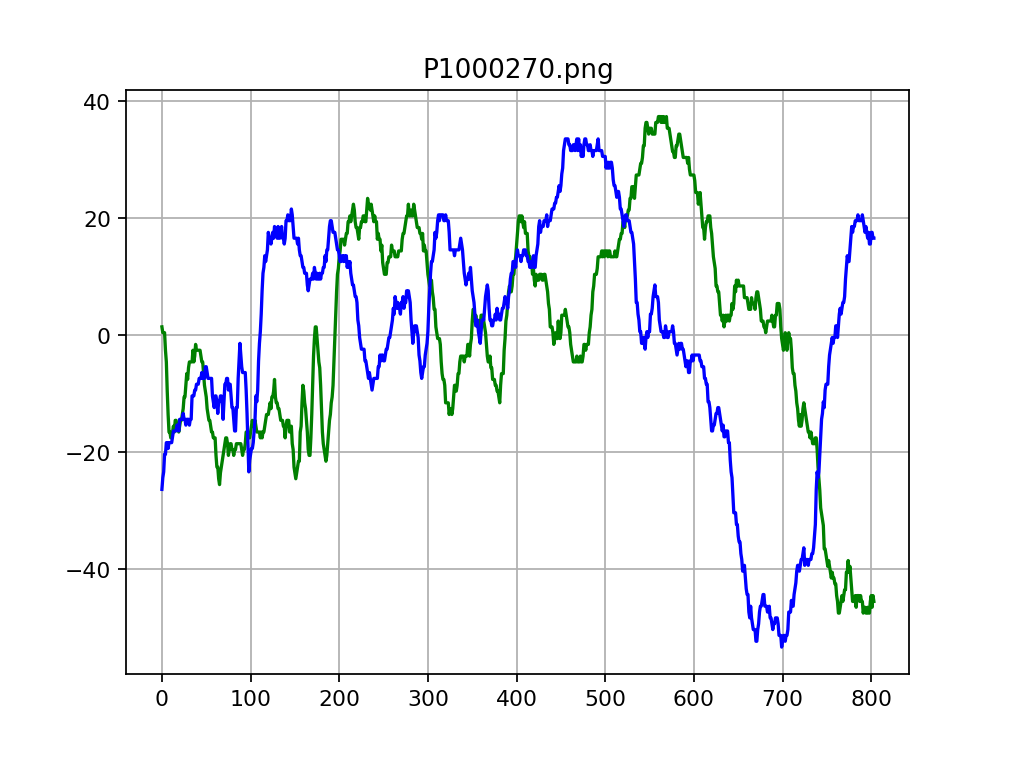

804 804


In [7]:
# Adjusting to the mean amplitude
mean_left = np.mean(amps_left_orig); print('mean_left', mean_left)
amps_left = amps_left_orig-mean_left 
mean_right = np.mean(amps_right_orig); print('mean_right',mean_right)
amps_right = amps_right_orig-mean_right

plt.figure()
ixrange_left_shifted = ixrange_left - ixrange_left[0]
ixrange_right_shifted = ixrange_right - ixrange_right[0]
plt.plot(ixrange_left_shifted,amps_left,'g')
plt.plot(ixrange_right_shifted,amps_right,'b')
plt.title(Filename)
plt.grid(True)

print(len(ixrange_left_shifted),len(ixrange_right_shifted))

length of correlation function = 1607
index_to_max_corrfun = 85


/var/folders/d4/79k8920n66j07rbcltjlhjx00000gr/T/ipykernel_13151/1004891056.py:7: RuntimeWarning: divide by zero encountered in divide
  weights = nxcorr/(offset-np.abs(ixrcorrange))


<IPython.core.display.Javascript object>


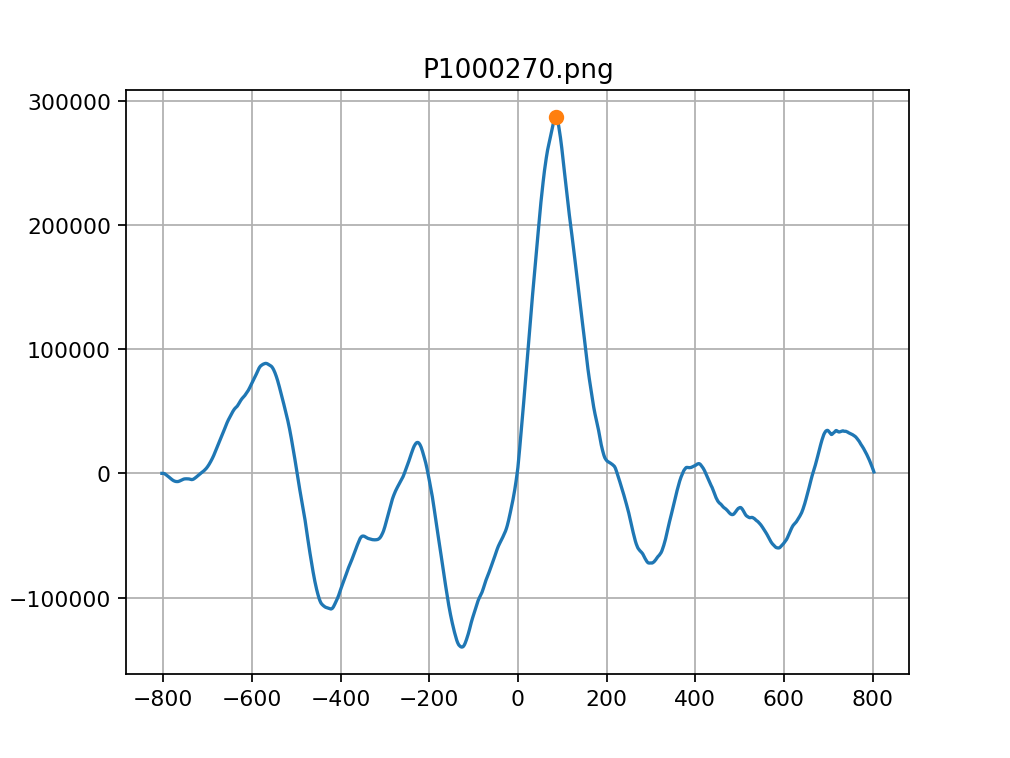

<IPython.core.display.Javascript object>


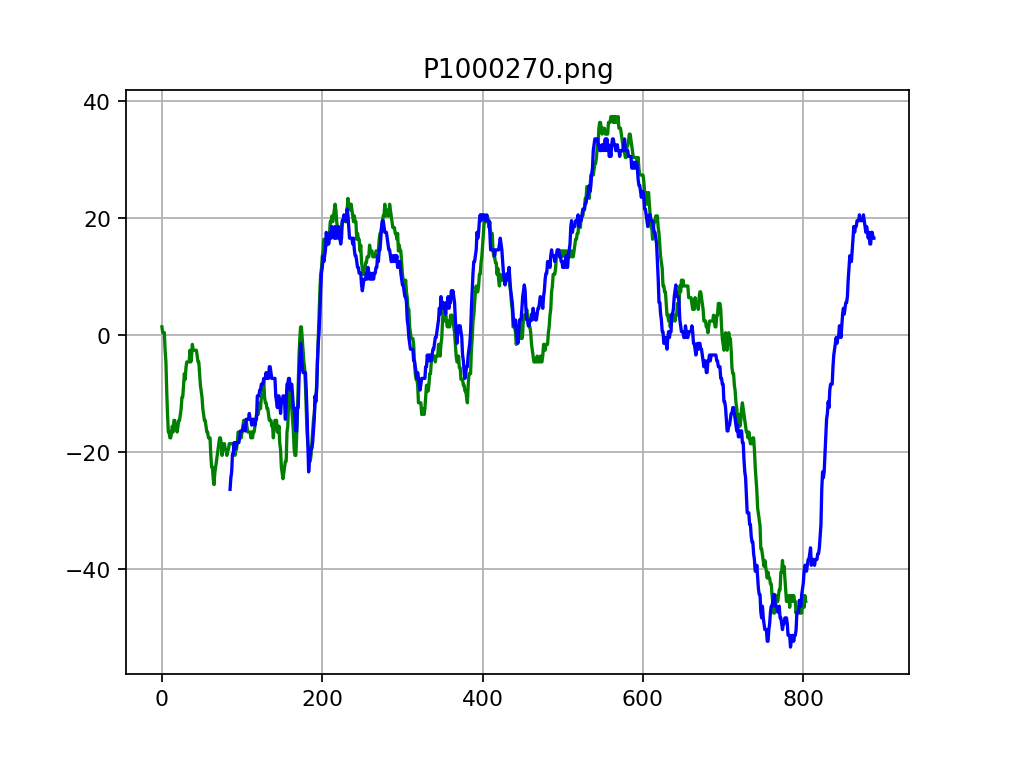

Text(0.5, 1.0, 'P1000270.png')

In [8]:
# Examining the weighted correlation function of a row
# corrfun = np.correlate(amps_right,amps_left,'full')
corrfun = np.correlate(amps_left,amps_right,'full')
nxcorr = len(corrfun); print('length of correlation function =', nxcorr)
offset = int(nxcorr/2)
ixrcorrange = np.arange(0,nxcorr)-offset
weights = nxcorr/(offset-np.abs(ixrcorrange))
# corrfunweighted = corrfun*weights
corrfunweighted = corrfun

seekmaxrange = 300
index_to_max_corrfun = np.argmax(corrfunweighted[ixmid-seekmaxrange:ixmid+seekmaxrange])
max_corrfun = np.max(corrfunweighted[ixmid-seekmaxrange:ixmid+seekmaxrange])
index_to_max_corrfun += ixmid-seekmaxrange-offset
print('index_to_max_corrfun =', index_to_max_corrfun)

plt.figure()
plt.plot(ixrcorrange,corrfunweighted)
plt.plot(index_to_max_corrfun,max_corrfun,'o')
plt.grid(True)
plt.title(Filename)

# Superimposing amplitudes of a row at the first peak in the correlation function
plt.figure()
plt.plot(ixrange_left-ixrange_left[0],amps_left,'g')
plt.plot(ixrange_right-ixrange_right[0]+index_to_max_corrfun,amps_right,'b')
plt.grid(True)
plt.title(Filename)

### Working with edge detection
See https://stackabuse.com/opencv-edge-detection-in-python-with-cv2canny/. This has more flexibility in specifying thresholds than I could find using other resources, such as 

- imgrayedges = imgray.filter(ImageFilter.FIND_EDGES)
- imgrayedges.save(r"Edge_Sample.png")

In [9]:
# Load the file as a grayscale
imgcv2 = cv2.imread(Filename, cv2.IMREAD_GRAYSCALE)
print(np.shape(imgcv2))

(758, 1848)


(758, 1848)
(538, 1848)
538 804


<IPython.core.display.Javascript object>


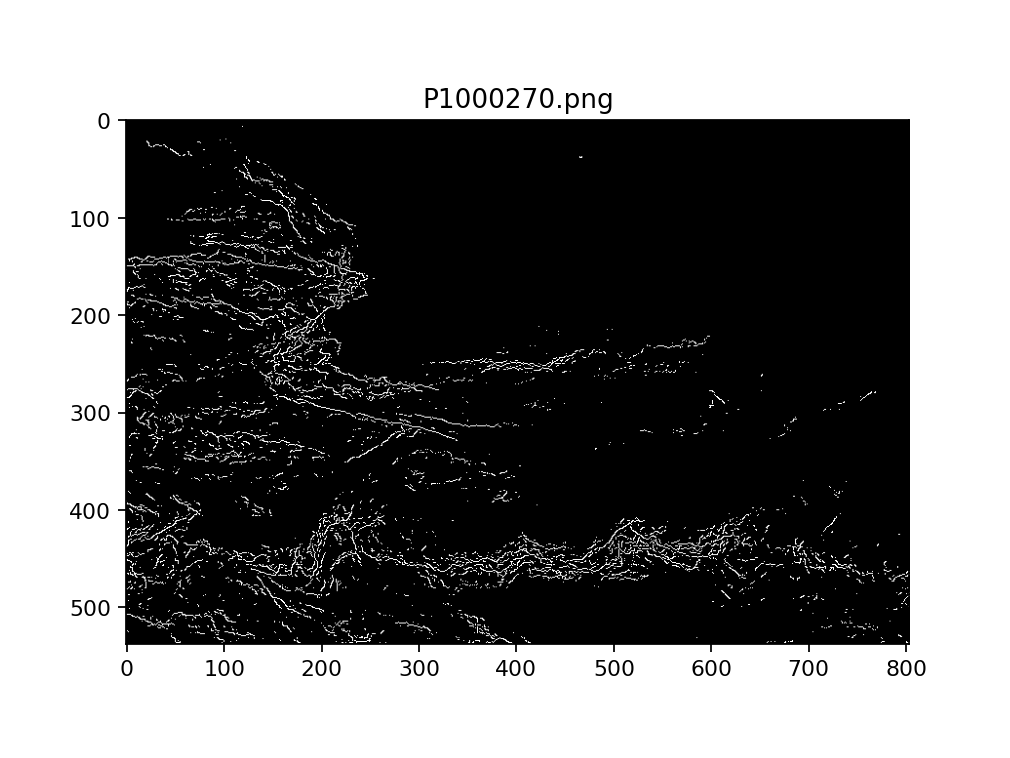

<IPython.core.display.Javascript object>


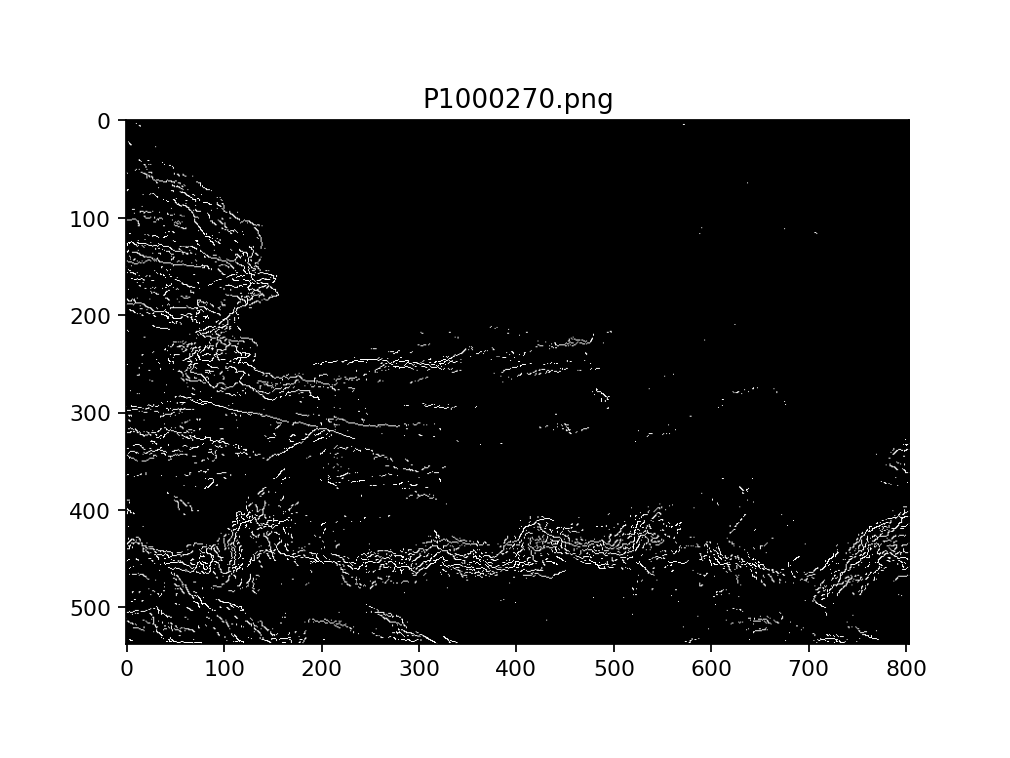

<IPython.core.display.Javascript object>


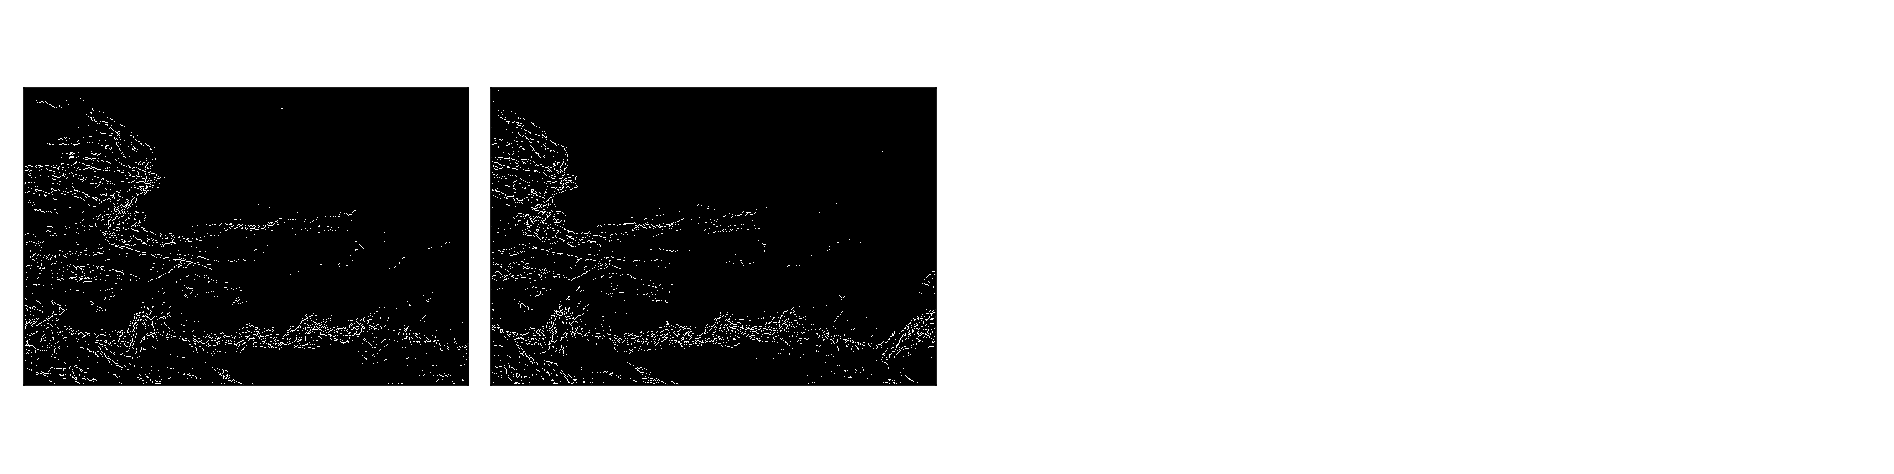

<IPython.core.display.Javascript object>


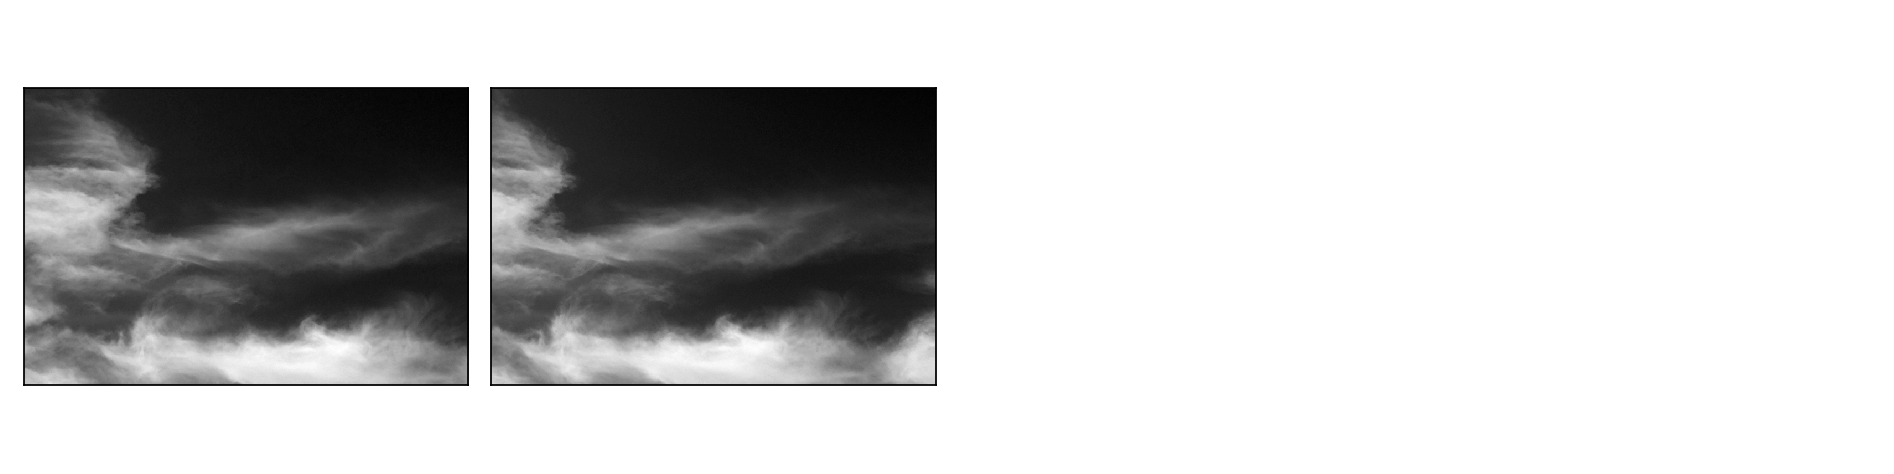

<IPython.core.display.Javascript object>


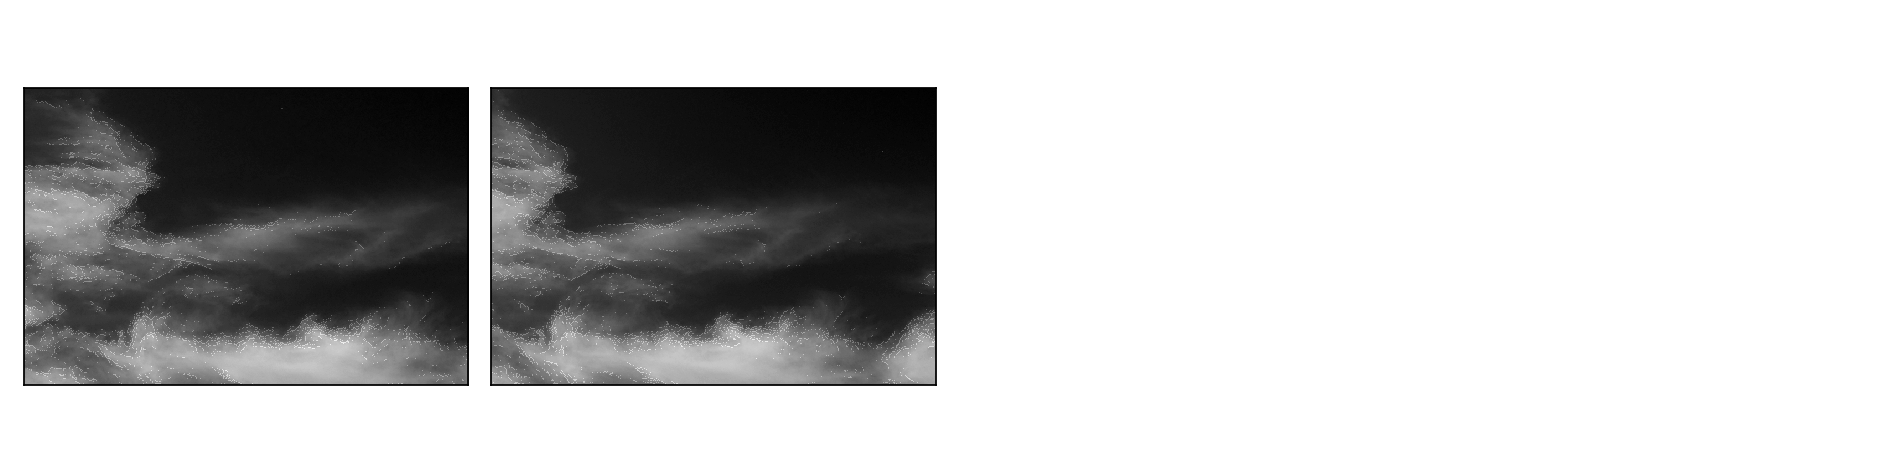

In [10]:
# Trimming off a bit from top and bottom
print(np.shape(imgcv2))
topoffset = 110
botoffset = 110
iyrange_edges = np.arange(topoffset,ny-botoffset)
imgcv2_trimmed = imgcv2[iyrange_edges,:]
print(np.shape(imgcv2_trimmed))

# Also separating left and right
imgcv2_trimmed_left = imgcv2_trimmed[:,ixrange_left]
imgcv2_trimmed_right = imgcv2_trimmed[:,ixrange_right]

# Recording these dimensions for later
ny_trimmed, nx_trimmed = np.shape(imgcv2_trimmed_left)
print(ny_trimmed, nx_trimmed)

# Detecting edges
edge_threshold = 20
edges_left = cv2.Canny(imgcv2_trimmed_left, edge_threshold,edge_threshold)
edges_right = cv2.Canny(imgcv2_trimmed_right, edge_threshold,edge_threshold)
edgecv2 = cv2.Canny(imgcv2, edge_threshold,edge_threshold)

# Specifying the x-axis ranges for these
ny_edges_left,nx_edges_left = np.shape(edges_left)
ixrange_edges_left = np.arange(0,nx_edges_left)
ny_edges_right,nx_edges_right = np.shape(edges_right)
ixrange_edges_right = np.arange(0,nx_edges_right)

# # This is just a double-check
# edgecv2_trimmed = cv2.Canny(imgcv2_trimmed, edge_threshold,edge_threshold)
# plt.figure()
# plt.imshow(edgecv2_trimmed, cmap='gray')

# This shows the edges individually
plt.figure()
plt.imshow(edges_left, cmap='gray')
plt.title(Filename)
plt.figure()
plt.imshow(edges_right, cmap='gray')
plt.title(Filename)

# This shows the edge heat maps side by side
plot_dwt([edges_left, edges_right])
plot_dwt([imgcv2_trimmed_left,imgcv2_trimmed_right])
plot_dwt2([[imgcv2_trimmed_left,edges_left], [imgcv2_trimmed_right,edges_right]],alpha=0.2)

538 1607


<IPython.core.display.Javascript object>


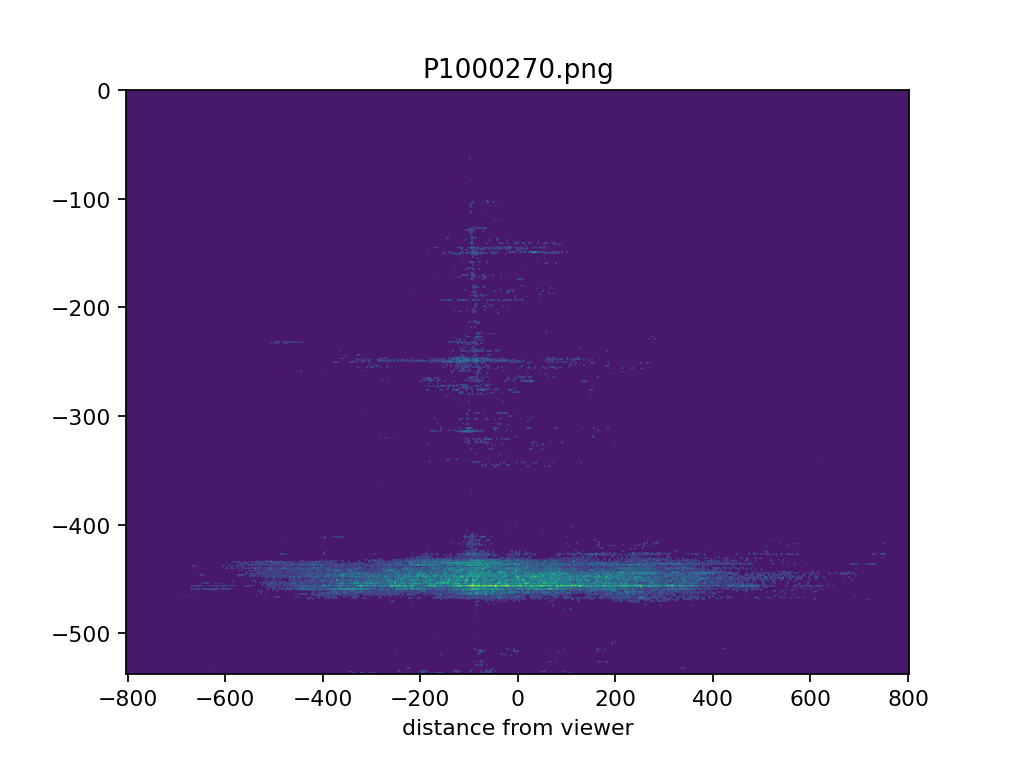

<IPython.core.display.Javascript object>


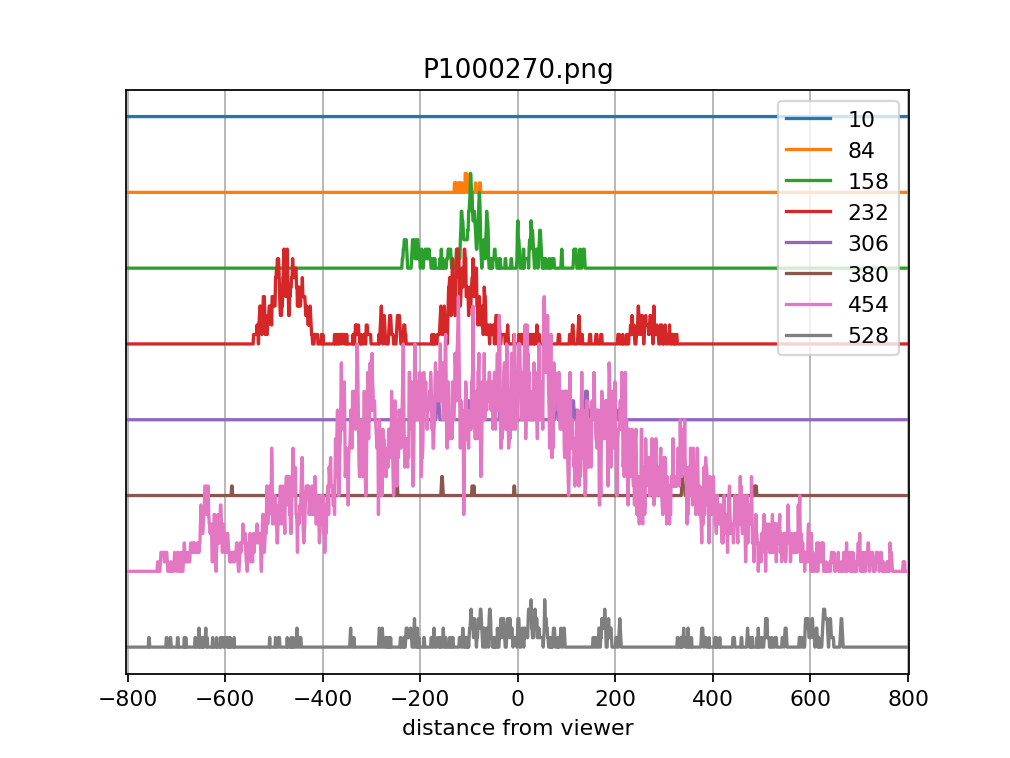

([], [])

In [11]:
corrfun_edges = correlate2d(edges_right,edges_left) # This order (right,left) makes closer objects farther to the left
ny_edges,nx_edges = np.shape(corrfun_edges); print(ny_edges,nx_edges)

offset_edges = int(nx_edges/2)
ixrcorrange_edges = np.arange(0,nx_edges)-offset_edges
iyrcorrange_edges = np.arange(0,ny_edges)

plt.figure()
plt.contourf(ixrcorrange_edges,-np.flipud(iyrcorrange_edges),np.flipud(corrfun_edges))
plt.title(Filename)
plt.xlabel('distance from viewer')

plt.figure()
ampmax = np.max(corrfun_edges)
nslices=8; rowstart = 10; rowstop = ny_edges-rowstart
rowfloat = np.linspace(rowstart,rowstop,nslices);
rowint = rowfloat.astype(int)
dv = 5; vstart=(nslices-1)*dv
for i in range(nslices):
    voffset = vstart -i*dv
    thisrow = rowint[i]
    plt.plot(ixrcorrange_edges,corrfun_edges[thisrow,:]/ampmax*dv*5+voffset,label=str(thisrow))
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim([np.min(ixrcorrange_edges),np.max(ixrcorrange_edges)])
plt.xlabel('distance from viewer')
plt.title(Filename)
plt.yticks([])

In [12]:
# ### Studing row 240 for P1000270
# row_num = iysample - topoffset; print('looking at row', row_num, 'of the trimmed image')
# fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, 1)

# ax1.plot(ixrange_edges_left,imgcv2_trimmed_left[row_num,:],'g')
# ax1.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax1.grid(True)
# ax1.set_ylabel('amps')

# ax2.plot(ixrange_edges_left,edges_left[row_num,:],'g')
# ax2.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax2.grid(True)
# ax2.set_ylabel('edges')

# offset_for_right = -80
# ax3.plot(ixrange_edges_right-offset_for_right,imgcv2_trimmed_right[row_num,:],'b')
# ax3.set_xlim([ixrange_edges_right[0],ixrange_edges_right[-1]])
# ax3.grid(True)
# ax3.set_ylabel('amps')

# ax4.plot(ixrange_edges_right-offset_for_right,edges_right[row_num,:],'b')
# ax4.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax4.grid(True)
# ax4.set_ylabel('edges')

# offset_for_right = -120
# ax5.plot(ixrange_edges_right-offset_for_right,imgcv2_trimmed_right[row_num,:],'cyan')
# ax5.set_xlim([ixrange_edges_right[0],ixrange_edges_right[-1]])
# ax5.grid(True)
# ax5.set_ylabel('amps')

# ax6.plot(ixrange_edges_right-offset_for_right,edges_right[row_num,:],'cyan')
# ax6.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax6.grid(True)
# ax6.set_ylabel('edges')

# offset_for_right = -480
# ax7.plot(ixrange_edges_right-offset_for_right,imgcv2_trimmed_right[row_num,:],'teal')
# ax7.set_xlim([ixrange_edges_right[0],ixrange_edges_right[-1]])
# ax7.grid(True)
# ax7.set_ylabel('amps')

# ax8.plot(ixrange_edges_right-offset_for_right,edges_right[row_num,:],'teal')
# ax8.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax8.grid(True)
# ax8.set_ylabel('edges')

# offset_for_right = 300
# ax9.plot(ixrange_edges_right-offset_for_right,imgcv2_trimmed_right[row_num,:],'navy')
# ax9.set_xlim([ixrange_edges_right[0],ixrange_edges_right[-1]])
# ax9.grid(True)
# ax9.set_ylabel('amps')

# ax10.plot(ixrange_edges_right-offset_for_right,edges_right[row_num,:],'navy')
# ax10.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax10.grid(True)
# ax10.set_ylabel('edges')




### Lesson for P1000270, row 240
- -80 (blue) is a good match for green's thick cloud, which spans from the left up to about 200 pixels.
- -120 (cyan) is a good match for green's thin cloud, broadly around 400-700 pixels.
- -480 (teal) and +300 (navy) result from mis-matches between these two clouds.

So .. of the three peaks seen in the correlation function for row 240 (P1000270), the middle one (spanning roughly -80 to -120 pixels) is actually a superposition of the thick cloud and a thin one. Since -80 lies to the right of -120, we'd conclude that the thick cloud is farther away (consistent with what it looks like in steroscopic view). The other two peaks are meaningless.

In [13]:
# ### Studing row 471 for P1000270
# row_num = iysample - topoffset; print('looking at row', row_num, 'of the trimmed image')
# fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)

# ax1.plot(ixrange_edges_left,imgcv2_trimmed_left[row_num,:],'g')
# ax1.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax1.grid(True)
# ax1.set_ylabel('amps')

# ax2.plot(ixrange_edges_left,edges_left[row_num,:],'g')
# ax2.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax2.grid(True)
# ax2.set_ylabel('edges')

# offset_for_right = -93
# ax3.plot(ixrange_edges_right-offset_for_right,imgcv2_trimmed_right[row_num,:],'b')
# ax3.set_xlim([ixrange_edges_right[0],ixrange_edges_right[-1]])
# ax3.grid(True)
# ax3.set_ylabel('amps')

# ax4.plot(ixrange_edges_right-offset_for_right,edges_right[row_num,:],'b')
# ax4.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax4.grid(True)
# ax4.set_ylabel('edges')

# offset_for_right = 240
# ax5.plot(ixrange_edges_right-offset_for_right,imgcv2_trimmed_right[row_num,:],'cyan')
# ax5.set_xlim([ixrange_edges_right[0],ixrange_edges_right[-1]])
# ax5.grid(True)
# ax5.set_ylabel('amps')

# ax6.plot(ixrange_edges_right-offset_for_right,edges_right[row_num,:],'cyan')
# ax6.set_xlim([ixrange_edges_left[0],ixrange_edges_left[-1]])
# ax6.grid(True)
# ax6.set_ylabel('edges')

### Lesson for P1000270, row 471
- -93 (blue) is a great match for green's cloud, whih spans the entire window.
- +240 (cyan) is a mismatch.

So .. of the three peaks seen in the correlation function for row 471 (P1000270), the middle one (spanning roughly -115 to -25 pixels) describes one big long cloud. Since the midpoint of this, at -93, betwween the -80 (thick) and the -120 (thin) clouds identified before for row 240, we'd conclude that this cloud is closer than the thick cloud at row 240, but farther away than the thin one (consistent with what it looks like in steroscopic view). The other two peaks in the correlation function are meaningless.

In [14]:
# Asking what resolution reduction would be needed to have enough information ...
ndepth_out = 10
fraction = (1/ndepth_out)**.5
print('percent =', fraction*100)

percent = 31.622776601683793


### Wavelets
See https://pywavelets.readthedocs.io/en/latest/index.html.

In [15]:
def get_dwt(original):
    from scipy import interpolate
    import pywt
    import pywt.data
    coeffs2 = pywt.dwt2(original, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    
    # This is needed because dwt2 produces an image that's half the size (both dimensions)
    ymax, xmax = np.shape(LH)
    yold = np.linspace(0,ymax-1,ymax)
    xold = np.linspace(0,xmax-1,xmax)

    ymaxnew, xmaxnew = np.shape(original); #print(ymaxnew,xmaxnew)
    ynew = np.linspace(0,ymax-1,ymaxnew); #print(ynew,np.shape(ynew))
    xnew = np.linspace(0,xmax-1,xmaxnew); #print(xnew,np.shape(xnew))
    
    f = interpolate.RectBivariateSpline(yold,xold,LH); LHnew = f(ynew,xnew)
    f = interpolate.RectBivariateSpline(yold,xold,HL); HLnew = f(ynew,xnew)

    return [LHnew,HLnew]

In [16]:
# dwt_left_list  = get_dwt(imgcv2_trimmed_left)
# dwt_right_list = get_dwt(imgcv2_trimmed_right)
# i=0;
# dwt_left  = dwt_left_list[i]
# dwt_right = dwt_right_list[i]
# plot_dwt([dwt_left,dwt_right])
# plot_dwt([imgcv2_trimmed_left,imgcv2_trimmed_right])
# plot_dwt2([[imgcv2_trimmed_left,dwt_left],   [imgcv2_trimmed_right,dwt_right]],  alpha=0.5)
# plot_dwt2([[imgcv2_trimmed_left,edges_left], [imgcv2_trimmed_right,edges_right]],alpha=0.5)

### An idea about resolution trade-off
OK, let's suppose we can live with a reduction in resolution. That fraction would be given by

$$
n_x \times n_y = (f n_x)\times (f n_y) \times n_z
$$

or $f = (1/n_z)^{1 \over 2}$. So if we wanted 10 depth values, we'd have to reduce the horizontal resolution to $30 \% $ of the original. Which is not so bad!

In [17]:
# Set up the geometry of the experiment
d = 1.1
D = d*10
theta_radians = np.arcsin(d/D)
theta_degrees = theta_radians*180/np.pi; print(theta_degrees)

5.739170477266787


538 804


<IPython.core.display.Javascript object>


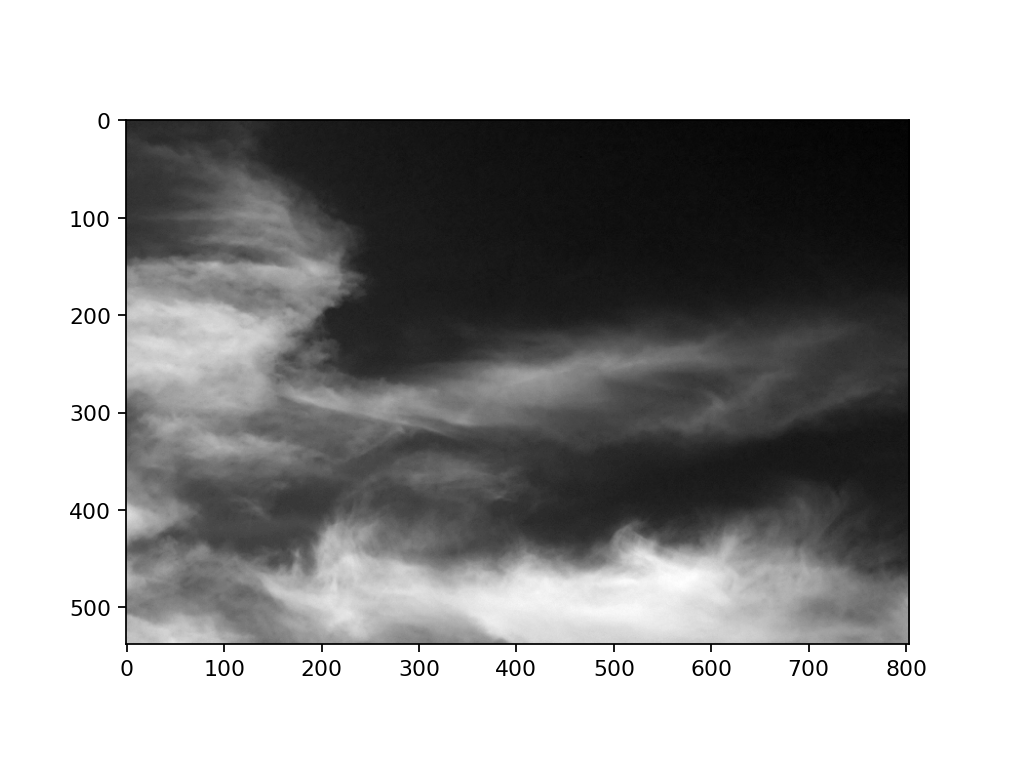

<IPython.core.display.Javascript object>


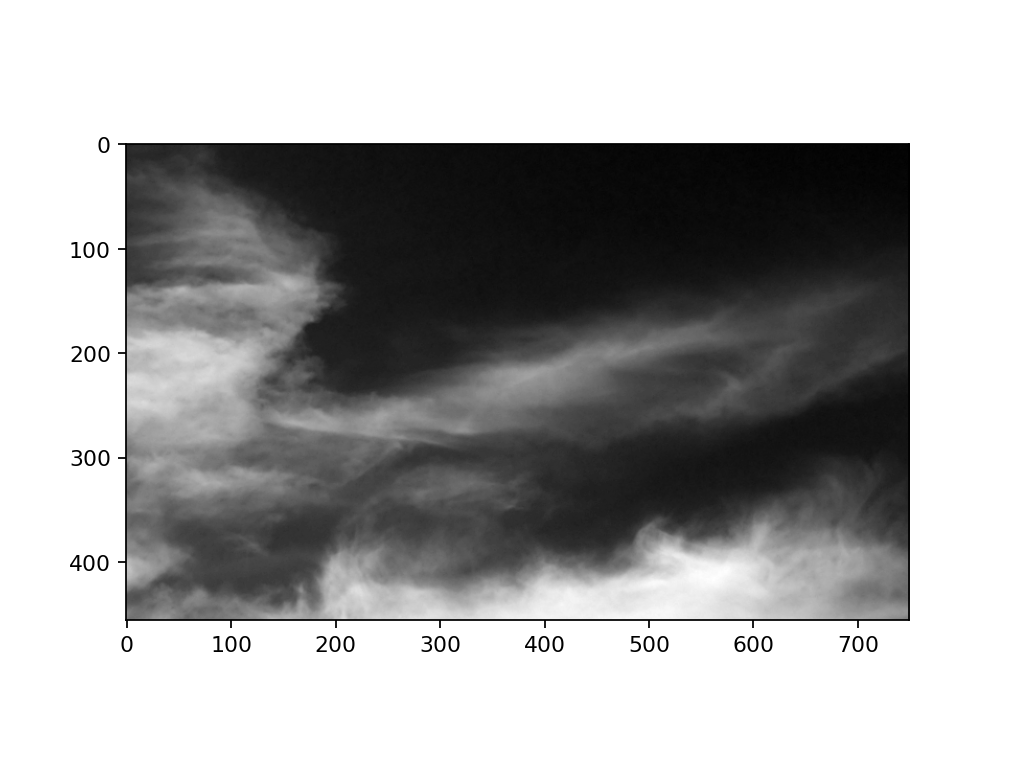

456 750


<IPython.core.display.Javascript object>


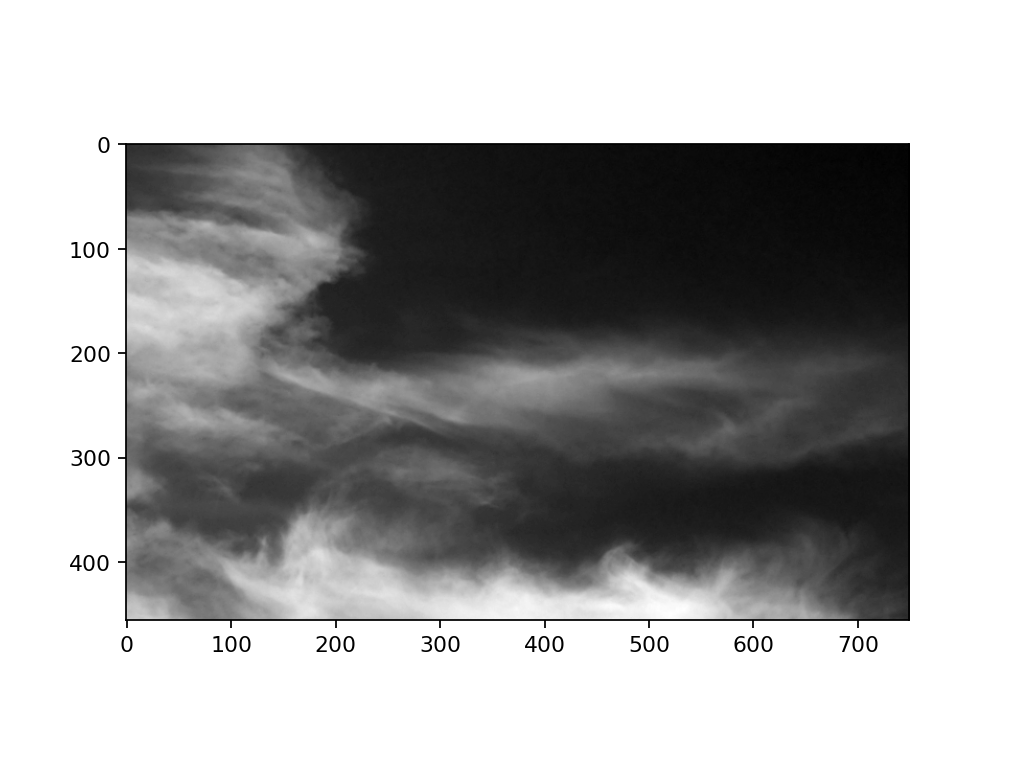

456 750


<IPython.core.display.Javascript object>


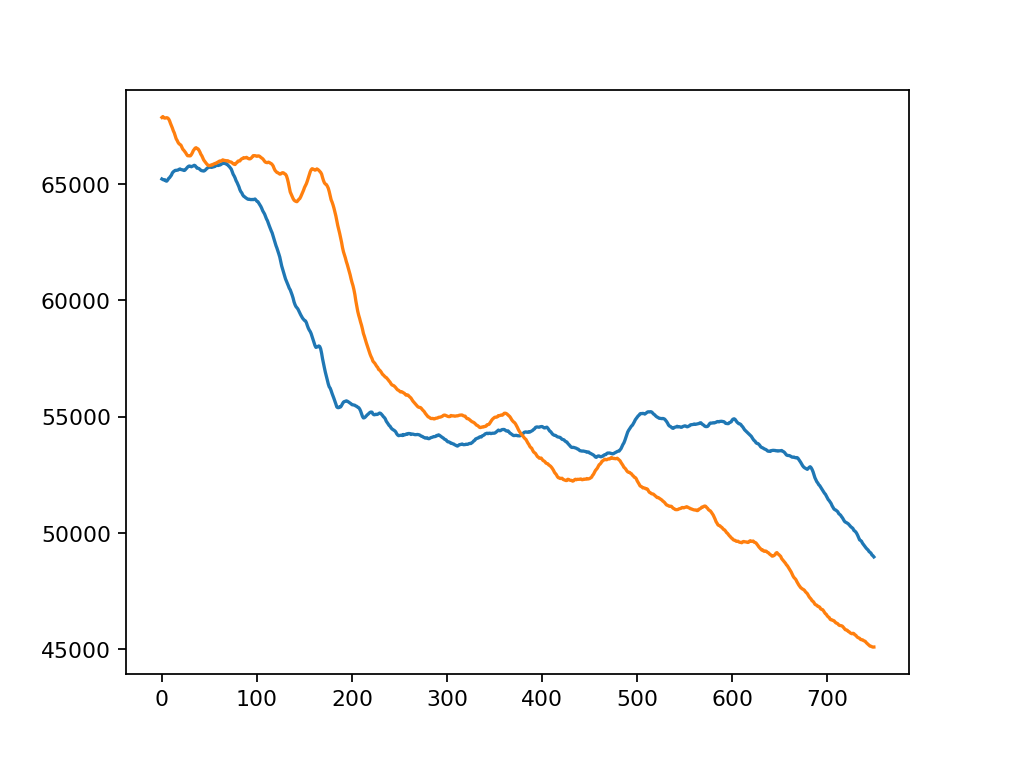

In [18]:
# This is testing whether the rotation code works

image = imgcv2_trimmed_left
ny_image, nx_image = np.shape(image)
print(ny_image,nx_image)
plt.figure()
plt.imshow(image,cmap=plt.cm.gray)

image_rotated_left,image_integrated_left = rotate_and_integrate(imgcv2_trimmed_left,theta_degrees)
plt.figure()
plt.imshow(image_rotated_left,cmap=plt.cm.gray)
ny_image_rotated_left, nx_image_rotated_left = np.shape(image_rotated_left)
print(ny_image_rotated_left,nx_image_rotated_left)

image_rotated_right,image_integrated_right = rotate_and_integrate(imgcv2_trimmed_left,-theta_degrees)
plt.figure()
plt.imshow(image_rotated_right,cmap=plt.cm.gray)
ny_image_rotated_right, nx_image_rotated_right = np.shape(image_rotated_right)
print(ny_image_rotated_right,nx_image_rotated_right)

plt.figure()
plt.plot(image_integrated_left)
plt.plot(image_integrated_right)

theta_eff_degrees 5.739170477266787
nx_rho 804
(804,)
(150, 804)


<IPython.core.display.Javascript object>


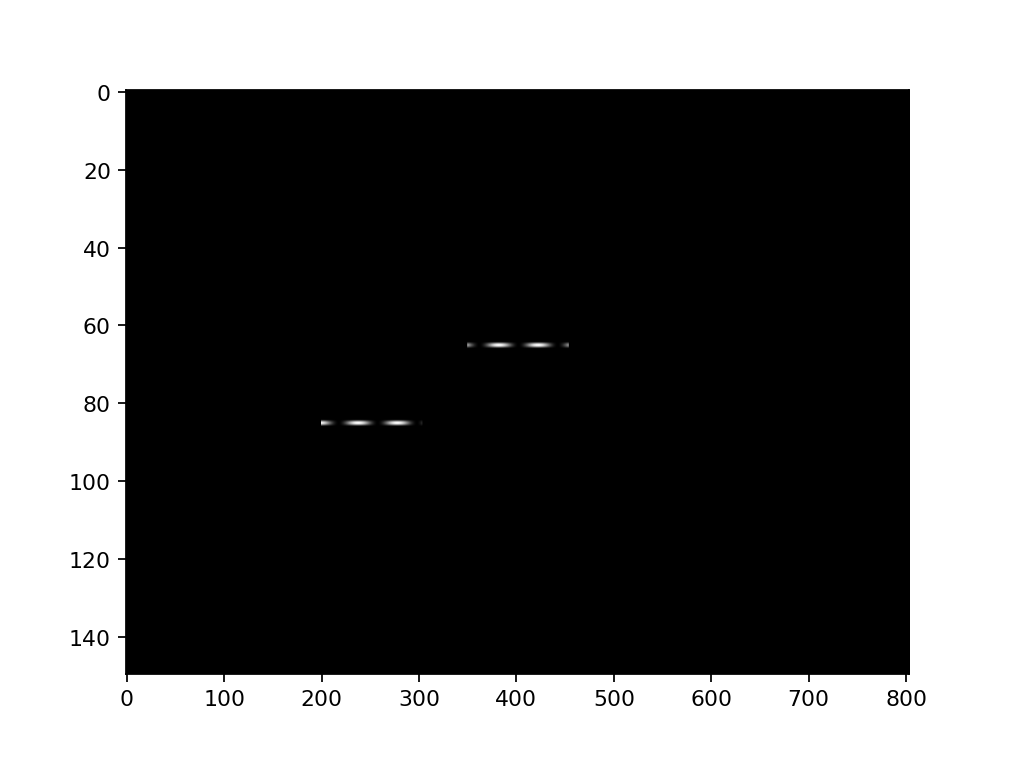

<IPython.core.display.Javascript object>


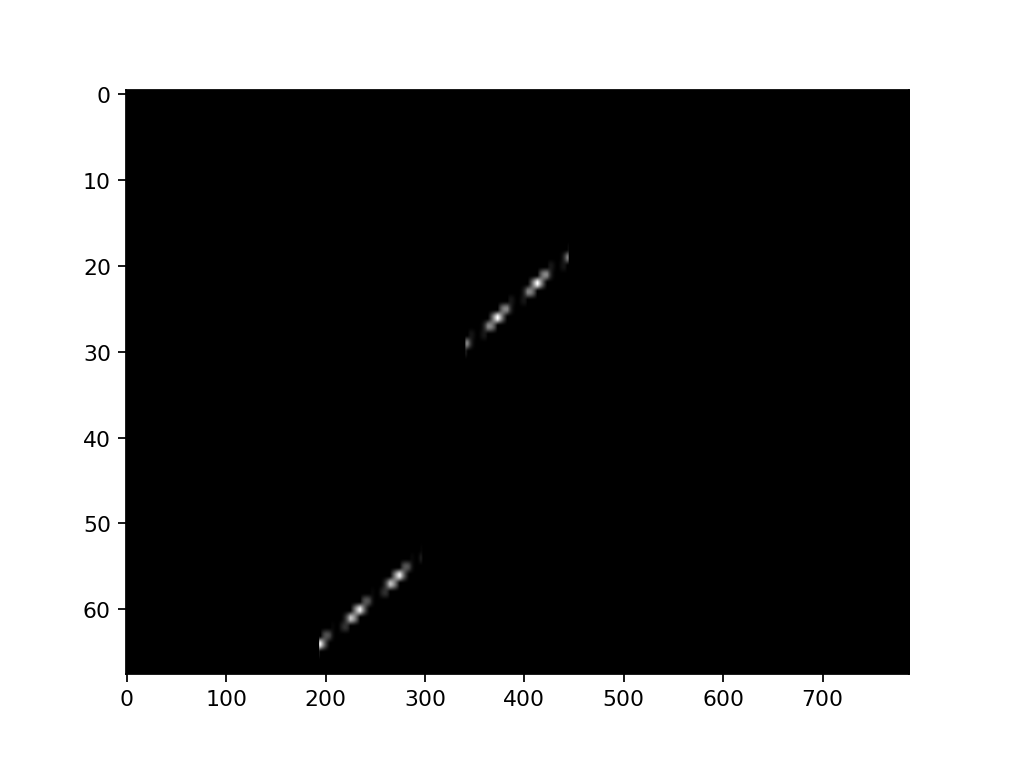

/var/folders/d4/79k8920n66j07rbcltjlhjx00000gr/T/ipykernel_13151/3984967073.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


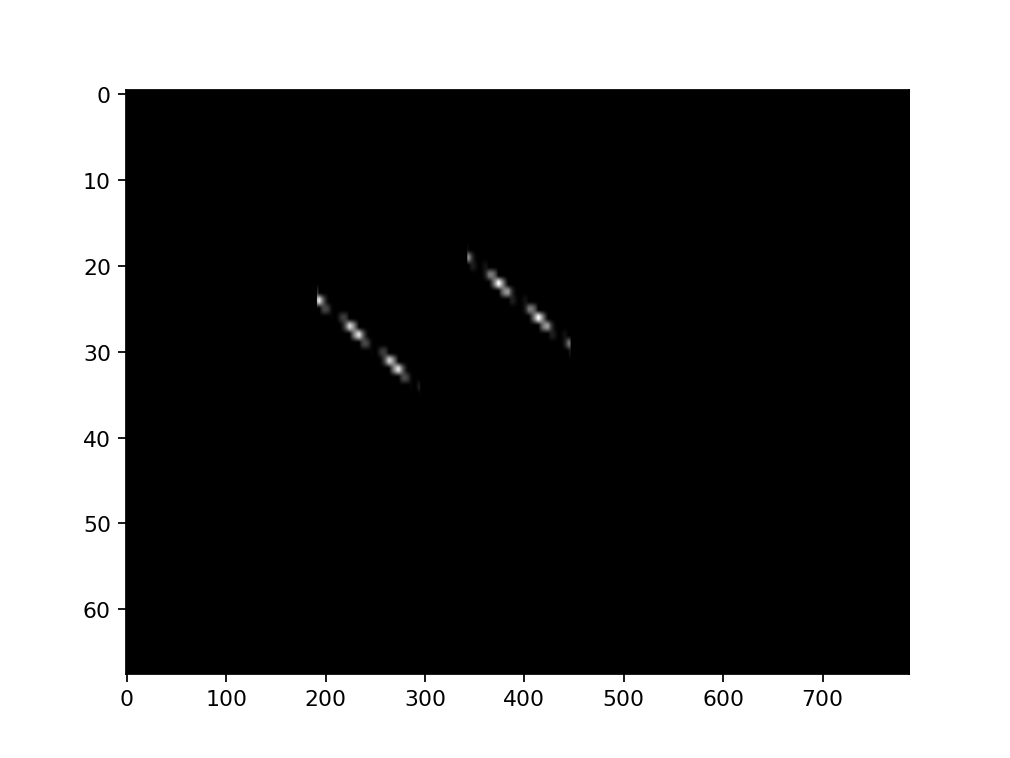

<IPython.core.display.Javascript object>


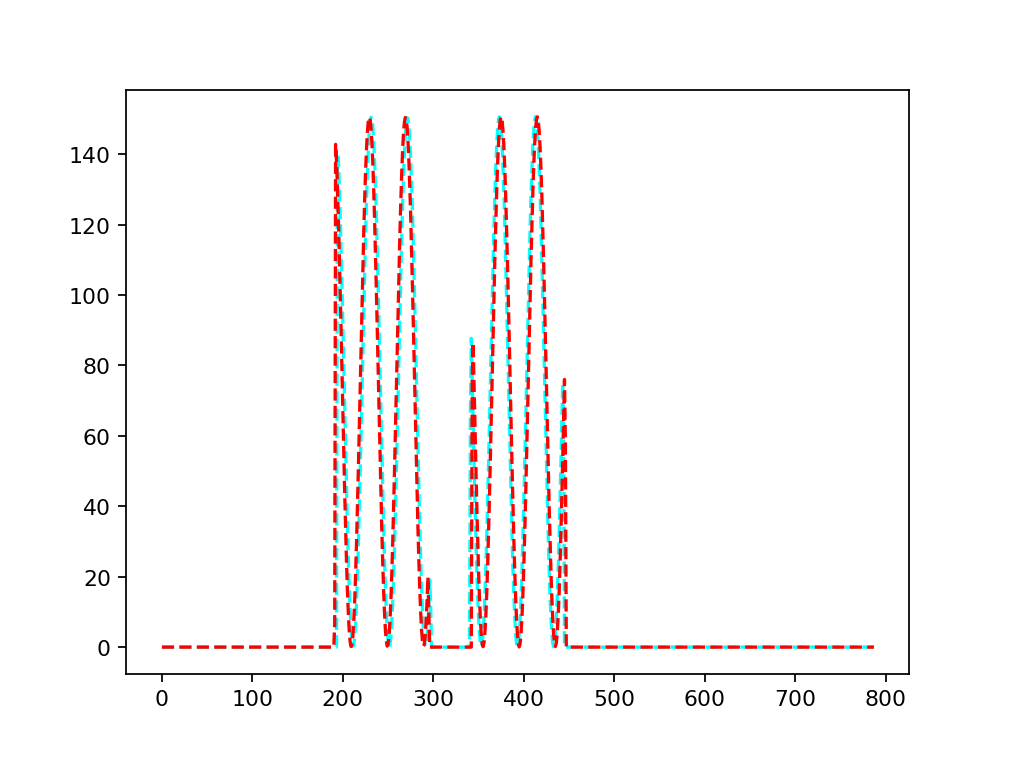

<IPython.core.display.Javascript object>


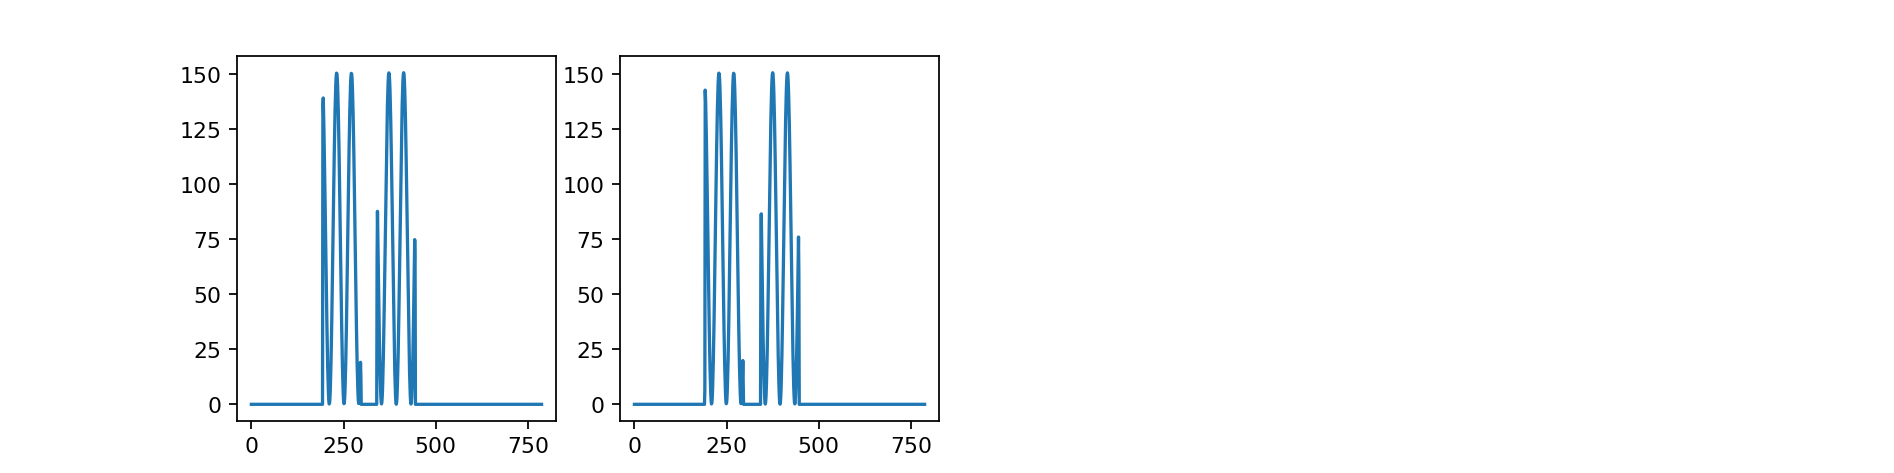

length of correlation function = 1575


<IPython.core.display.Javascript object>


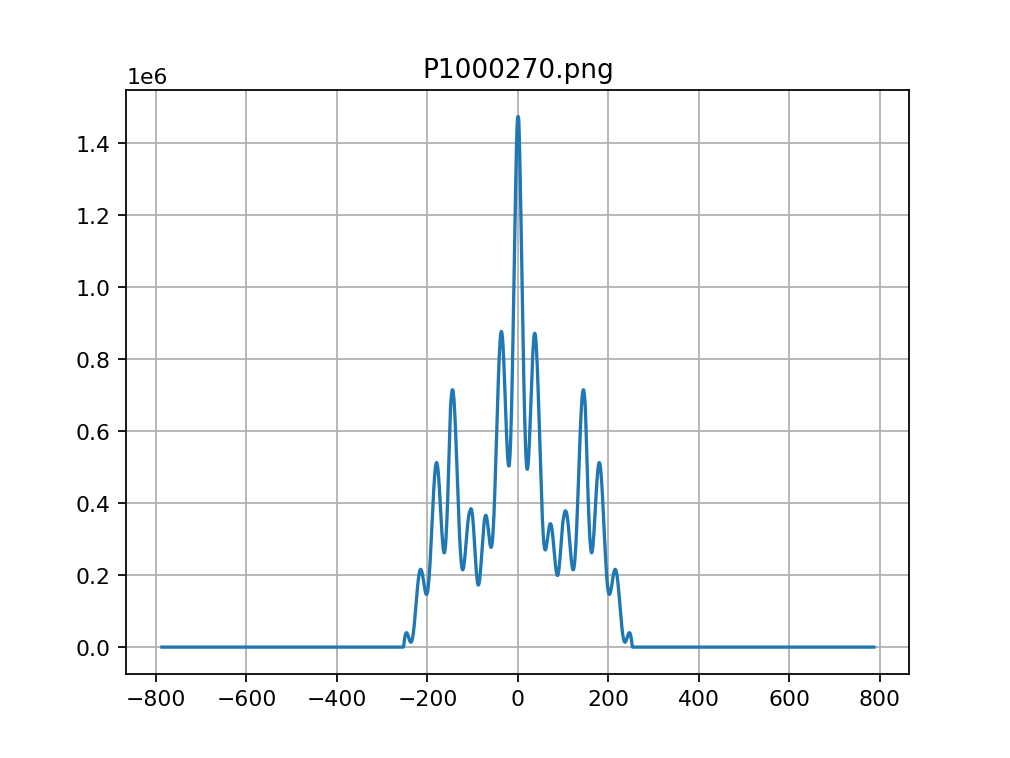

Text(0.5, 1.0, 'P1000270.png')

In [52]:
# Now we'll try out the forward model for a single horizontal raster (row)

# Effective angle given that the aspect ratio is not 1:1 (guessing here ... I don't know how to scale this)
aspect = 1
# theta_eff_radians = theta_radians/aspect
theta_eff_radians = theta_radians
theta_eff_degrees = theta_eff_radians*180/np.pi; print('theta_eff_degrees', theta_eff_degrees)

# Initialize the cloud density array
multiplier = 150
nx_rho = nx_trimmed; print('nx_rho',nx_rho)
nz_rho = int(150/aspect)
ioffset = int(10/aspect)
imidz_rho = int(nz_rho/2)
rho = np.zeros((nz_rho,nx_rho))
xrange_before_rotation = np.arange(0,nx_rho); print(np.shape(xrange_before_rotation))

rho[imidz_rho-ioffset,:] = np.sin(xrange_before_rotation/nx_rho*20*np.pi)**2*multiplier
rho[imidz_rho-ioffset,0:350]=0
rho[imidz_rho-ioffset,-350:]=0

rho[imidz_rho+ioffset,:] = np.sin(xrange_before_rotation/nx_rho*20*np.pi+5)**2*multiplier
rho[imidz_rho+ioffset,0:200]=0
rho[imidz_rho+ioffset,-500:]=0

print(np.shape(rho))
plt.figure()
plt.imshow(rho,cmap=plt.cm.gray,aspect='auto')

# Try out our rotation idea
rho_left,A_left = rotate_and_integrate(rho,theta_eff_degrees)
plt.figure()
plt.imshow(rho_left,cmap=plt.cm.gray,aspect='auto')

rho_right,A_right = rotate_and_integrate(rho,-theta_eff_degrees)
plt.figure()
plt.imshow(rho_right,cmap=plt.cm.gray,aspect='auto')

xrange = np.arange(0,np.size(A_left))
plt.figure()
plt.plot(xrange,A_left,'cyan',linestyle='--')
plt.plot(xrange,A_right,'red',linestyle='--')

fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(1, 4, 1); ax1.plot(xrange,A_left)
ax2 = fig.add_subplot(1, 4, 2); ax2.plot(xrange,A_right)

corrfun = np.correlate(A_left,A_right,'full')
nxcorr = len(corrfun); print('length of correlation function =', nxcorr)
offset = int(nxcorr/2)
ixrcorrange = np.arange(0,nxcorr)-offset

plt.figure()
plt.plot(ixrcorrange,corrfun)
plt.grid(True)
plt.title(Filename)

## 

ny_rho 538
dummy1, nz_rho, dummy2 538 150 804
nx_rho 788
shape of rho_3d (538, 150, 804)
shape of A_left_3d (and A_right_3d) (538, 788)


<IPython.core.display.Javascript object>


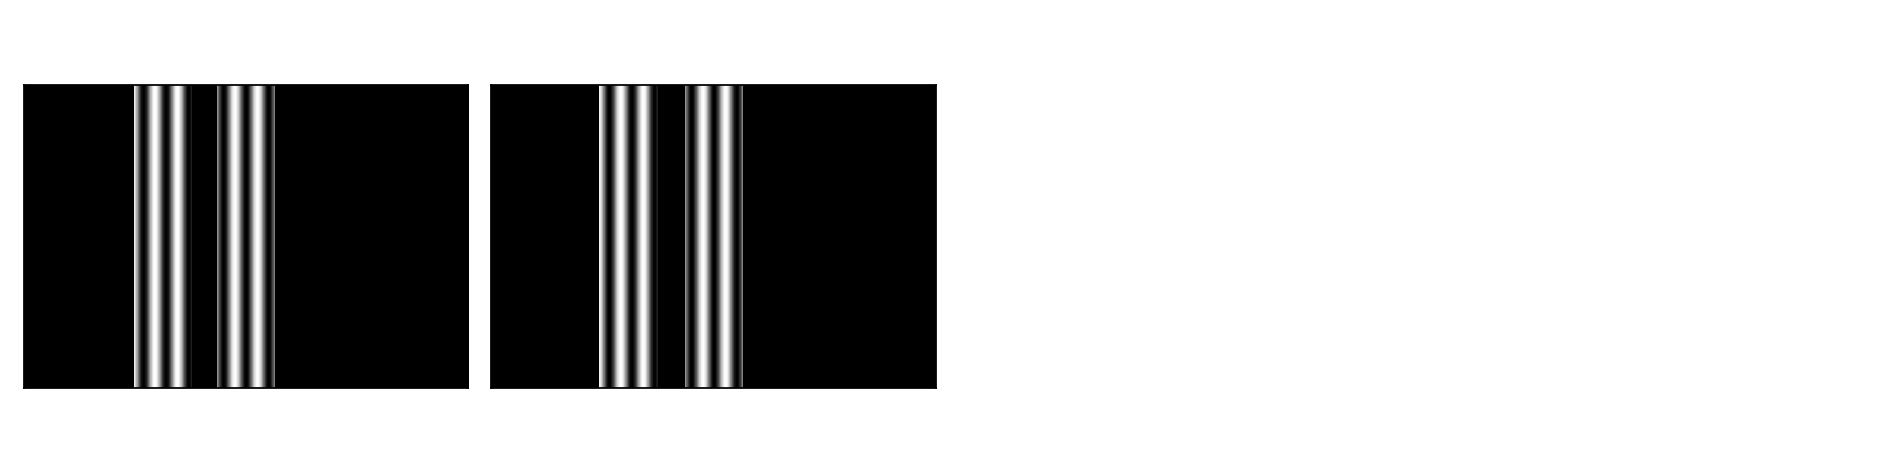

In [60]:
# Do again, but make it look like a cloud
ny_rho = ny_trimmed
print('ny_rho',ny_rho)

rho_3d = []
for i in range(ny_rho):
    rho_3d.append(rho)
dummy1, nz_rho, dummy2 = np.shape(rho_3d)
print('dummy1, nz_rho, dummy2', dummy1, nz_rho, dummy2) 
    
A_left_3d = []
A_right_3d = []
for i in range(ny_rho):
    rho_left,A_left = rotate_and_integrate(rho_3d[i],theta_eff_degrees)
    A_left_3d.append(A_left)
    rho_right,A_right = rotate_and_integrate(rho_3d[i],-theta_eff_degrees)
    A_right_3d.append(A_right)
dummy1, nx_rho = np.shape(A_left_3d)
print('nx_rho', nx_rho)   
print('shape of rho_3d', np.shape(rho_3d))
print('shape of A_left_3d (and A_right_3d)', np.shape(A_left_3d))
plot_dwt([A_left_3d,A_right_3d])

nx_rho,ny_rho,nz_rho 788 538 150
shape of rho_3d (538, 150, 788)
shape of rho_3d[0] (150, 788)
shape of A_left_3d (and A_right_3d) (538, 784)


<IPython.core.display.Javascript object>


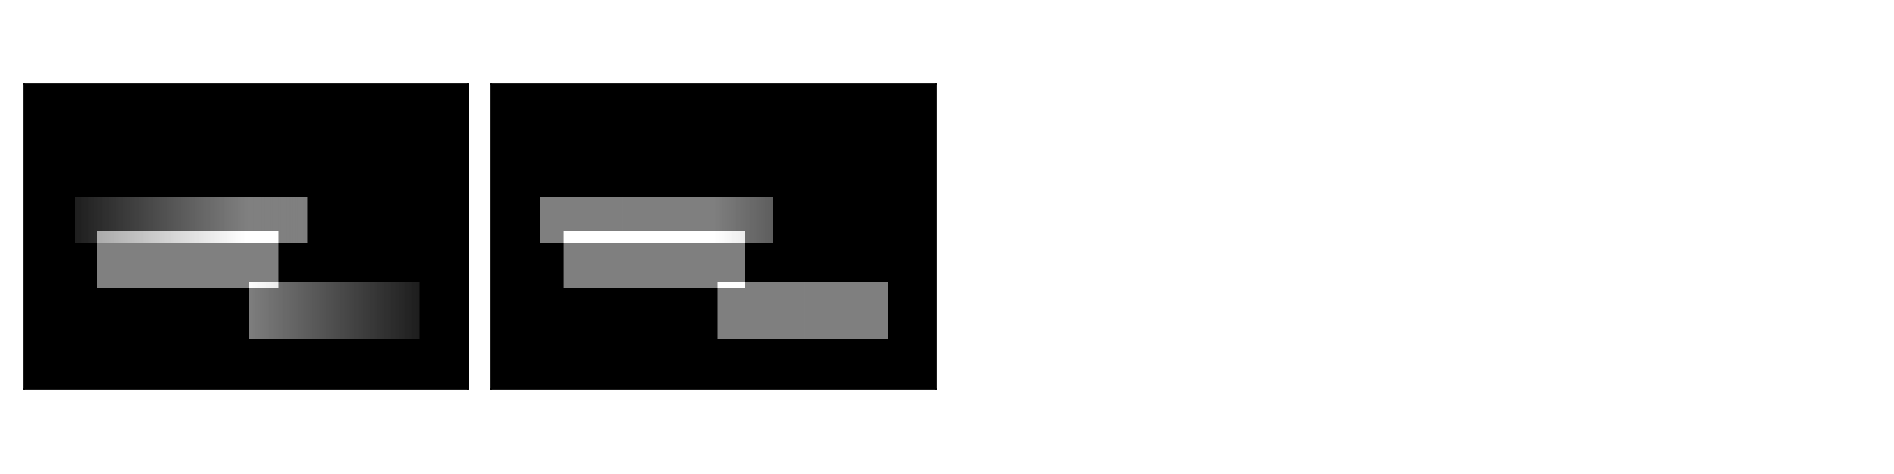

In [108]:
ny_rho = ny_trimmed
print('nx_rho,ny_rho,nz_rho',nx_rho,ny_rho,nz_rho)
rho_3d = np.zeros((ny_rho,nz_rho,nx_rho))
print('shape of rho_3d', np.shape(rho_3d))
print('shape of rho_3d[0]',np.shape(rho_3d[0]))

rho_3d[200:280,10:20,90:500] = 100
rho_3d[260:360,50:60,130:450] = 100
rho_3d[350:450,130:140,400:700] = 100

A_left_3d = []
A_right_3d = []
for i in range(ny_rho):
    rho_left,A_left = rotate_and_integrate(rho_3d[i],theta_eff_degrees/4)
    A_left_3d.append(A_left)
    rho_right,A_right = rotate_and_integrate(rho_3d[i],-theta_eff_degrees/4)
    A_right_3d.append(A_right)
print('shape of A_left_3d (and A_right_3d)', np.shape(A_left_3d))
# plot_dwt([A_left_3d,A_right_3d])
plot_dwt([A_right_3d,A_left_3d])

In [72]:
theta_eff_degrees

5.739170477266787

(538, 788)